In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zlib
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.utils import to_categorical
from keras.models import model_from_json
import h5py
import seaborn as sn
import pandas as pd

Using TensorFlow backend.


In [2]:
## Data Processing

# File Names
TRAIN_FILE = '../data/train'
TEST_FILE = '../data/test'

# Unpickling data
def unpickle(file):
    import cPickle
    f = open(file, 'r')
    d = cPickle.load(f)
    f.close()
    return d

# Get Training features and labels
def get_train_data(prep_img=True):
    return get_cifar100_data(TRAIN_FILE, prep_img)

# Get Testing features and labels
def get_test_data(prep_img=True):
    return get_cifar100_data(TEST_FILE, prep_img)

# Get Data
def get_cifar100_data(file_ip, prep_img=True, normalize=True, one_hot=True, num_labels=100):
    d = unpickle(file_ip)
    data = np.array(d['data']).astype('float32')
    labels = np.array(d['fine_labels'])
    data, labels = data_shuffle(data, labels)
    if prep_img:
        data = prep_images(data)
    if one_hot:
        labels = to_categorical(labels, num_labels)
    if normalize:
        data = data.astype('float32')
        data = data / 255.
    return data, labels

def data_shuffle(data, labels):
    labels = labels[:,np.newaxis]
    c = np.column_stack((data, labels))
    for _ in xrange(10):
        np.random.shuffle(c)
    d, l = c[:,:-1], c[:,-1]
    return d, l

# Convert vector to image
def prep_images(images, shape=(32,32,3)):
    return images.reshape(-1,shape[0], shape[1], shape[2])

# Return Label from one hot encoding
def return_label(one_hot_lab):
    op = np.zeros(len(one_hot_lab))
    for i in xrange(len(one_hot_lab)):
        op[i] = np.argmax(one_hot_lab[i])
    return op

# Generate Confusion Matrix:
def prep_confusion_matrix(y_test, y_pred, num_of_classes=100):
    op = np.zeros((num_of_classes, num_of_classes))
    for i in xrange(len(y_test)):
        op[int(y_test[i]),int(y_pred[i])] += 1
    return op

In [3]:
# Preconstructed Models & Weights

MODELA = 'model_A'
MOD_A_WT_25 = 'mod_A_weights_25'
MOD_A_WT_45 = 'mod_A_weights_45'

MODELB = 'model_B'
MOD_B_WT_100 = 'mod_b_wts_100'

In [4]:
# Getting the testing data
x_test, y_test = get_test_data()
# Getting the training data
# UnComment if training.
# x_train, y_train = get_train_data()

In [5]:
# Retrieving the model from the saved model file
f = open(MODELB, 'r')
json_str = f.readlines()
json_str = json_str[0]

In [6]:
# Loading the model.
model = model_from_json(json_str)

# Model Summary(Architecture)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [7]:
# Loading the pre-trained weights
# Note: Please comment this if you want to train the model instead.
model.load_weights(MOD_B_WT_100)

In [8]:
# Compiling the Model
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

# UnComment to train the model.
# model.fit(x_train, y_train, batch_size=50, epochs=5, validation_split=0.2)

In [9]:
# Evaluating the Model for accuracy on testing data.
model.evaluate(x_test, y_test, batch_size=50, verbose=1)

10000/10000 [==============================] - 33s    


[2.8597138720750808, 0.4395999997854233]

In [10]:
# Getting the predictions
predictions = model.predict(x_test, batch_size=50, verbose=1)

10000/10000 [==============================] - 27s    


In [11]:
# Getting the predicted labels
pred_labels = return_label(predictions)

In [12]:
# De-one-hotting labels
y_tst_dh = return_label(y_test)

# Preparing the confusion Matrix
conf_mat = prep_confusion_matrix(y_tst_dh, pred_labels)

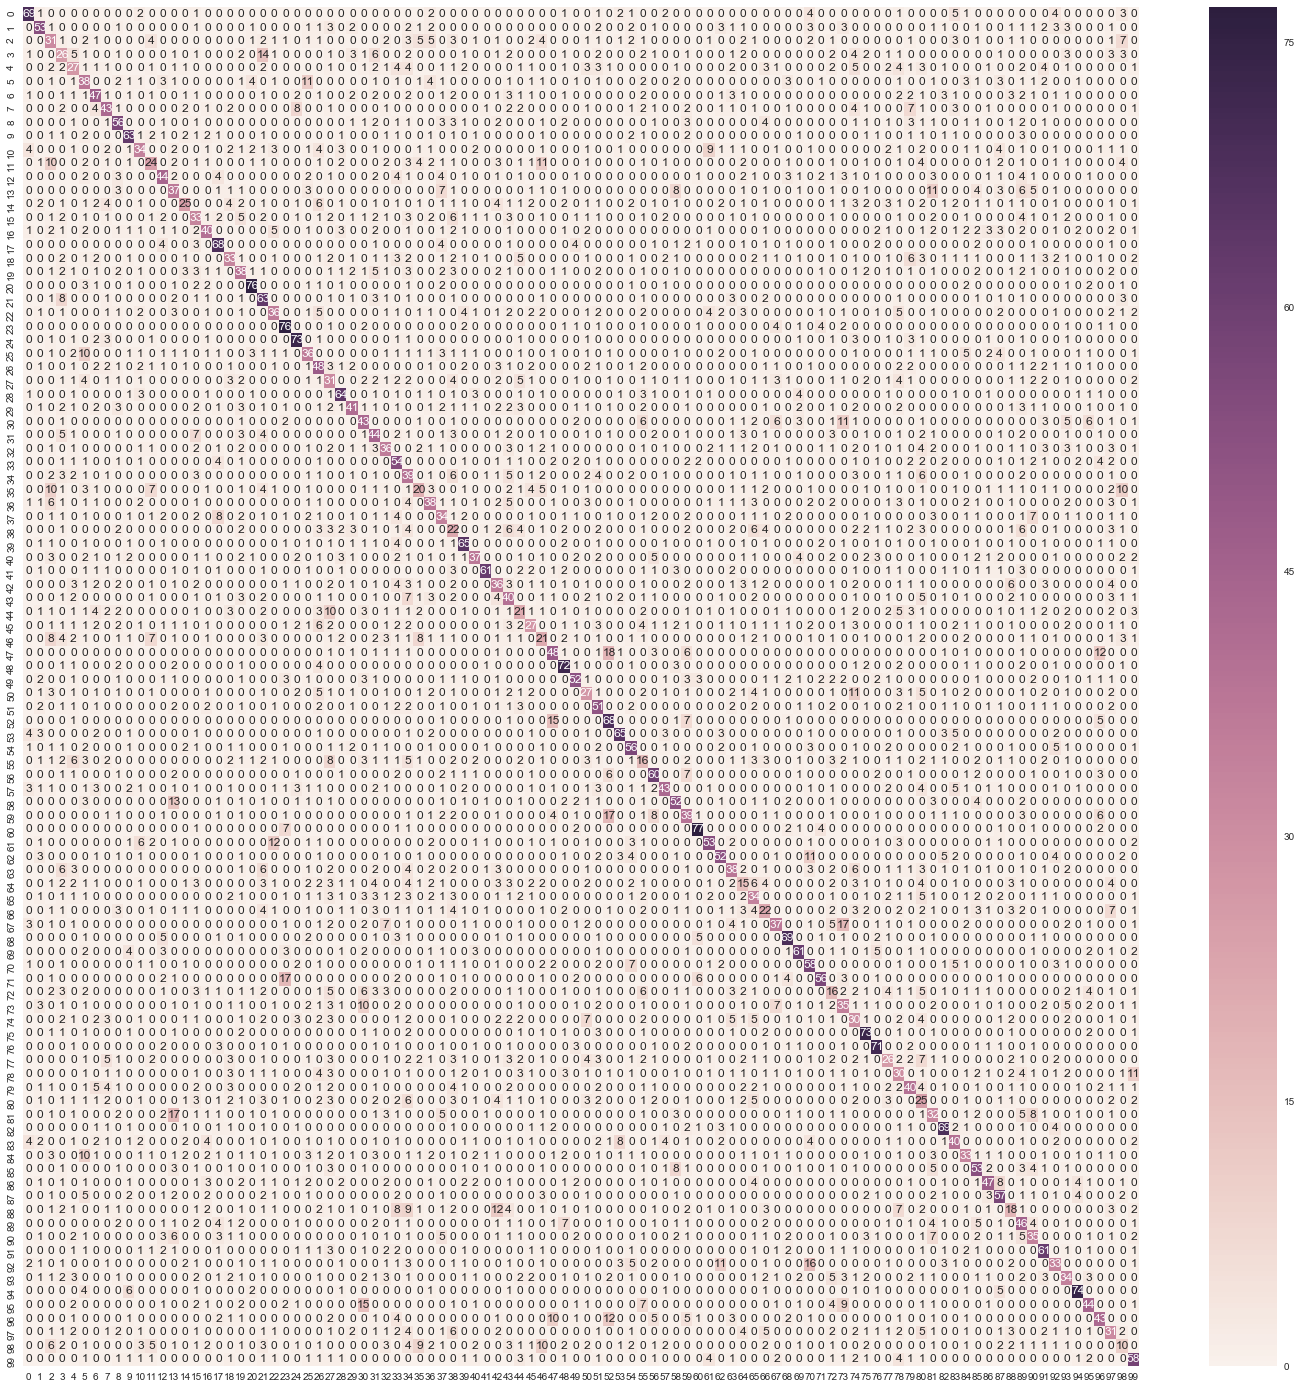

In [13]:
# Plotting the Confusion Matrix
df_cm = pd.DataFrame(conf_mat, index = [i for i in xrange(100)],
                  columns = [i for i in xrange(100)])
plt.figure(figsize = (25,25))
sn.heatmap(df_cm, annot=True)